In [40]:
import json
import os
from pyproj import Transformer
import dfm_tools as dfmt
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [41]:
point = 'lugano_melide'
model = 'lugano_1y_seq_corr_thick'
depth_plot = -20 # (for timeserie plots)
date_plot_profile = datetime(2023,8,1,0,0)

# Get plot parameters

In [42]:
with open(os.path.join(os.path.dirname(os.getcwd()), 'config_points.json'), 'r') as file:
    config_points = json.load(file)[point]
    
lat_station_wgs84 = config_points['lat_station_wgs84']
long_station_wgs84 = config_points['long_station_wgs84']
measure_file_path = config_points['measure_file_path']

In [43]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781") # WGS84 projection to CH1903 projection
lat_station_ch1903, long_station_ch1903 = transformer.transform(lat_station_wgs84, long_station_wgs84)

In [44]:
with open('config_plots.json', 'r') as file:
    config_plots = json.load(file)[model]
    
file_nc_map = config_plots['file_nc_map']

In [45]:
if 'partition_number' in config_plots:
    output_dir = config_plots['working_dir']
    n_part = config_plots['partition_number']
    file_nc_map = []
    for n in range(n_part):
        file_nc_map.append(os.path.join(output_dir, f'FlowFM_{n:04}_map.nc'))

# Import data

In [46]:
fm_map = dfmt.open_partitioned_dataset(file_nc_map)

>> xu.open_dataset() with 1 partition(s): 1 [nodomainvar] : 0.54 sec


In [47]:
x_list = fm_map['mesh2d_face_x'].values
y_list = fm_map['mesh2d_face_y'].values
min_distance = sys.maxsize
fm_index_nFaces = None
for i in range(len(x_list)):
    # Calculate distance to the given coordinate
    distance = (x_list[i] - lat_station_ch1903) ** 2 + (y_list[i] - long_station_ch1903) ** 2
    if distance < min_distance:
        min_distance = distance
        fm_index_nFaces = i

In [48]:
fm_depths = fm_map['mesh2d_layer_z'].values
fm_index_depth = (np.abs(fm_depths - depth_plot)).argmin()
fm_timestamps = fm_map['time'].values
fm_timeserie = fm_map['mesh2d_tem1'].values[:, fm_index_nFaces, fm_index_depth]
fm_profil = fm_map['mesh2d_tem1'].values[:, fm_index_nFaces, :].transpose()

# Plot data

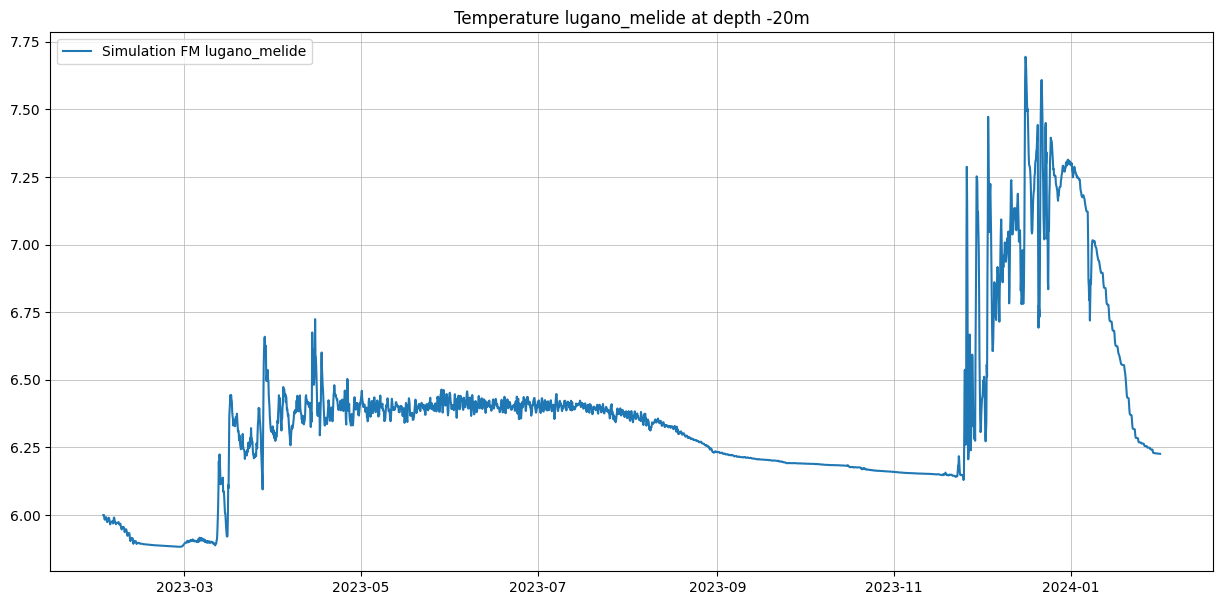

In [49]:
fig = plt.figure(figsize=(15, 7))
plt.plot(fm_timestamps,fm_timeserie, label=f'Simulation FM {point}')
plt.title(f"Temperature {point} at depth {depth_plot}m")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

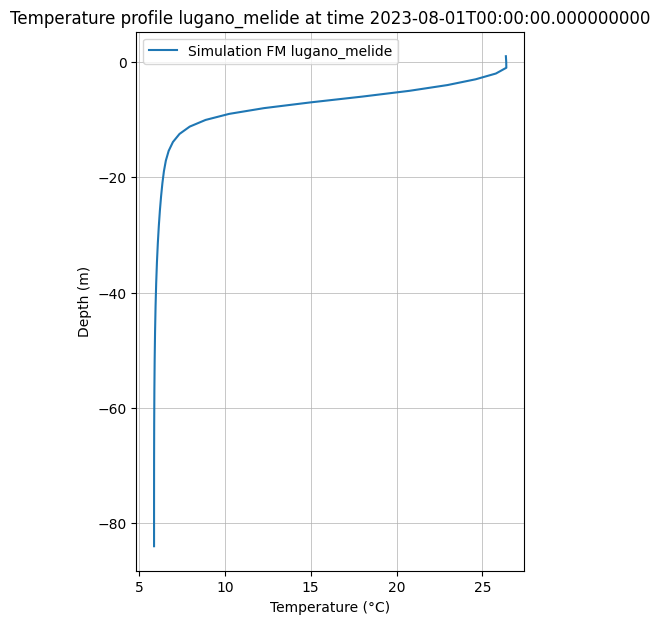

In [50]:
i_fm_date_plot = (np.abs(np.array(fm_timestamps) - np.datetime64(date_plot_profile))).argmin()
fig = plt.figure(figsize=(5, 7))
plt.plot(fm_profil[:,i_fm_date_plot], fm_depths, label=f'Simulation FM {point}') 
plt.title(f"Temperature profile {point} at time {fm_timestamps[i_fm_date_plot]}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.xlabel('Temperature (°C)')
plt.legend()
plt.show()

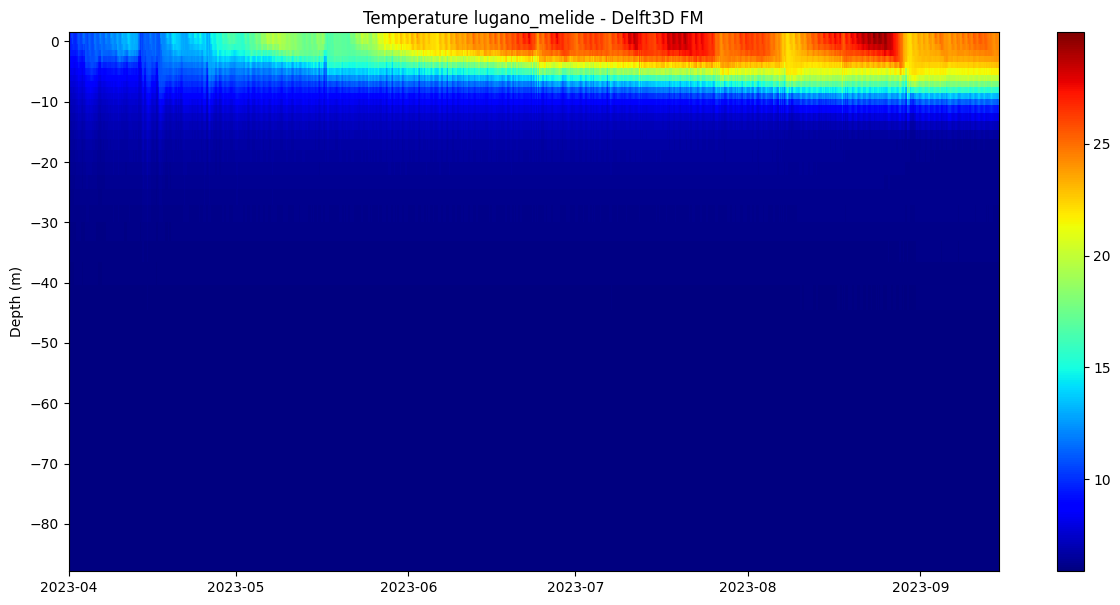

In [53]:
start_date = np.datetime64('2023-04-01') 
end_date = np.datetime64('2023-09-15')

# Find the index of the closest datetime object to start_date and end_date in meas_timestamps
fm_start_index = min(range(len(fm_timestamps)), key=lambda i: abs(fm_timestamps[i] - start_date))
fm_end_index = min(range(len(fm_timestamps)), key=lambda i: abs(fm_timestamps[i] - end_date))
mask_nan_depth = np.isnan(fm_profil[:,0])==False

fig = plt.figure(figsize=(15,7))
plt.pcolormesh(fm_timestamps[fm_start_index:fm_end_index + 1], fm_depths[mask_nan_depth], fm_profil[mask_nan_depth,fm_start_index:fm_end_index + 1], cmap='jet')
plt.title(f"Temperature {point} - Delft3D FM")
plt.ylabel("Depth (m)")
plt.colorbar()
plt.show()